В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [25]:
import warnings
warnings.filterwarnings("ignore")

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import lightgbm as lgb


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [3]:
df = pd.read_csv('bank-customer-churn-prediction-dlu/train.csv', index_col=0)
cols_to_delete = ['CustomerId']
df.drop(columns=cols_to_delete, inplace=True)
df['Surname'] = df['Surname'].astype('category')
df['Geography'] = df['Geography'].astype('category')
df['Gender'] = df['Gender'].astype('category')


target_col = 'Exited'
train, val = split_train_val(df, target_col)

In [4]:
train

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,
7180,Mays,682.0,France,Male,30.0,1.0,131394.56,1.0,1.0,1.0,143952.24,0.0
10393,Ch'eng,684.0,France,Female,39.0,2.0,178058.06,1.0,1.0,0.0,145518.31,0.0
80,Ch'in,705.0,Germany,Male,35.0,6.0,116320.68,2.0,1.0,0.0,174431.01,0.0
3365,K?,669.0,Spain,Male,58.0,0.0,0.00,2.0,0.0,1.0,51565.98,0.0
12236,Trevisani,707.0,France,Male,21.0,3.0,0.00,2.0,1.0,1.0,148564.76,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9493,Onyekachi,633.0,France,Female,33.0,4.0,0.00,2.0,0.0,0.0,123537.05,0.0
8463,Tsao,673.0,France,Female,40.0,1.0,0.00,1.0,1.0,1.0,47832.82,0.0
8143,Hsia,621.0,France,Male,29.0,8.0,0.00,2.0,1.0,1.0,133535.29,0.0


In [5]:
input_cols = list(train.columns)
input_cols.remove(target_col)
X_train, y_train = separate_inputs_targets(train, input_cols, target_col)
X_val, y_val = separate_inputs_targets(val, input_cols, target_col)

In [6]:
X_train

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,
7180,Mays,682.0,France,Male,30.0,1.0,131394.56,1.0,1.0,1.0,143952.24
10393,Ch'eng,684.0,France,Female,39.0,2.0,178058.06,1.0,1.0,0.0,145518.31
80,Ch'in,705.0,Germany,Male,35.0,6.0,116320.68,2.0,1.0,0.0,174431.01
3365,K?,669.0,Spain,Male,58.0,0.0,0.00,2.0,0.0,1.0,51565.98
12236,Trevisani,707.0,France,Male,21.0,3.0,0.00,2.0,1.0,1.0,148564.76
...,...,...,...,...,...,...,...,...,...,...,...
9493,Onyekachi,633.0,France,Female,33.0,4.0,0.00,2.0,0.0,0.0,123537.05
8463,Tsao,673.0,France,Female,40.0,1.0,0.00,1.0,1.0,1.0,47832.82
8143,Hsia,621.0,France,Male,29.0,8.0,0.00,2.0,1.0,1.0,133535.29


In [7]:
y_train

id
7180     0.0
10393    0.0
80       0.0
3365     0.0
12236    0.0
        ... 
9493     0.0
8463     0.0
8143     0.0
11512    0.0
9360     0.0
Name: Exited, Length: 12000, dtype: float64

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [28]:
X_train.dtypes

Surname            category
CreditScore         float64
Geography          category
Gender             category
Age                 float64
Tenure              float64
Balance             float64
NumOfProducts       float64
HasCrCard           float64
IsActiveMember      float64
EstimatedSalary     float64
dtype: object

In [21]:
# df['Surname'] = df['Surname'].astype('category')
# df['Geography'] = df['Geography'].astype('category')
# df['Gender'] = df['Gender'].astype('category')

Для зручності, щоб не робити перетворення для категоріальних даних після того, як ми розбили на тестовий і навчальний датасети, винесла це на початок, як тільки зчитуємо датасет, одразу перетворюємо на категоріальні.

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [31]:
# pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     ------------------------------------- 124.9/124.9 MB 17.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [15]:
xgb_clf = XGBClassifier(
    max_depth=4,
    n_estimators=30,
    enable_categorical=True,  # для категорійних ознак
    use_label_encoder=False,  # щоб уникнути попереджень, якщо використовуєте нові версії XGBoost
    missing=np.nan,  # явне вказування пропущених значень
#     device='cuda'
)

xgb_clf.fit(X_train, y_train)

train_pred = xgb_clf.predict(X_train)
val_pred = xgb_clf.predict(X_val)

print(classification_report(y_train, train_pred, digits=4))
print(classification_report(y_val, val_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9398    0.9743    0.9567      9558
         1.0     0.8824    0.7555    0.8140      2442

    accuracy                         0.9297     12000
   macro avg     0.9111    0.8649    0.8854     12000
weighted avg     0.9281    0.9297    0.9277     12000

              precision    recall  f1-score   support

         0.0     0.9215    0.9477    0.9344      2390
         1.0     0.7694    0.6836    0.7240       610

    accuracy                         0.8940      3000
   macro avg     0.8454    0.8157    0.8292      3000
weighted avg     0.8906    0.8940    0.8916      3000



C:\Users\lyuda\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:27:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [16]:
# Calculate AUROC for training and validation datasets
train_auroc = roc_auc_score(y_train, train_pred)
val_auroc = roc_auc_score(y_val, val_pred)

print(f"Train AUROC: {train_auroc}")
print(f"Validation AUROC: {val_auroc}")

Train AUROC: 0.8648953267597335
Validation AUROC: 0.8156526510734617


Висновок: Видно, що на тренувальних даних моделька не навчилась до гарної якості, а отже, треба підбирати параметри для навчання краще, щоб можна було отримати більшу якість. У порівнянні з деревом рішень у мене вийшла десь така сама якість модельки.

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [28]:
# !pip install hyperopt

In [43]:
def objective(params):
    clf = xgb.XGBClassifier(
    n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        gamma=params['gamma'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        enable_categorical=True,
        use_label_encoder=False,
        missing=np.nan,
#         device='cuda',
        early_stopping_rounds=20
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False)
    pred = clf.predict(X_val)
    roc_auc = roc_auc_score(y_val, pred)

    return {'loss': -roc_auc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
#     use_label_encoder=False,
    missing=np.nan,
#     device='cuda',
)

final_clf.fit(X_train, y_train)
final_pred_train = final_clf.predict(X_train)
final_pred = final_clf.predict(X_val)
final_roc_auc_train = roc_auc_score(y_train, final_pred_train)
final_roc_auc = roc_auc_score(y_val, final_pred)
print("\n")
print("Точність на навчальній вибірці: {:.4f}".format(final_roc_auc_train))
print("Точність на валідаційній вибірці: {:.4f}".format(final_roc_auc))

100%|███████████████████████████████████████████████| 20/20 [00:06<00:00,  3.10trial/s, best loss: -0.8220694149118595]
Найкращі гіперпараметри:  {'colsample_bytree': 0.9192845263425653, 'gamma': 0.17406847712282525, 'learning_rate': 0.09839226777342926, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 300, 'reg_alpha': 0.26032282401831586, 'reg_lambda': 0.003555345293630774, 'subsample': 0.6969087650405057}


Точність на навчальній вибірці: 0.8858
Точність на валідаційній вибірці: 0.8182


Висновок, моделька стала зовсім трошки краще предіктити, але в цілому зміни в якості не великі.

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [32]:
# pip install lightgbm

In [33]:
cat_features = X_train.select_dtypes(include='category').columns
cat_feature_indexes = [X_train.columns.get_loc(col) for col in cat_features]

In [34]:
cat_features

Index(['Surname', 'Geography', 'Gender'], dtype='object')

In [37]:
lgb_clf = lgb.LGBMClassifier(
    max_depth=5,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,  # для автоматичного розпізнавання категорійних ознак
    missing=np.nan,  # явне вказування пропущених значень
    # device='cuda'  # використовувати GPU для прискорення обчислень
)

lgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)])

train_pred = lgb_clf.predict(X_train)
val_pred = lgb_clf.predict(X_val)

print(classification_report(y_train, train_pred, digits=4))
print(classification_report(y_val, val_pred, digits=4))

[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set with categorical_column=0,2,3, will be overridden by cat_feature=0,2,3. Current value: categorical_feature=0,2,3
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1316
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 11
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]:

In [38]:
# Calculate AUROC for training and validation datasets
train_auroc = roc_auc_score(y_train, train_pred)
val_auroc = roc_auc_score(y_val, val_pred)

print(f"Train AUROC: {train_auroc}")
print(f"Validation AUROC: {val_auroc}")

Train AUROC: 0.8626953867066862
Validation AUROC: 0.8136291926743947


Висновки: В цілому якість модельки без підбору гіперпараметрів в порівнянні з моделькою XGBoostClassifier майже така сама. Знову бачимо, що на навчальних даних моделька не навчилась на максимальної якості, що може означати, що алгоритм, який ми використовуємо ля навчання моделі не найкращий вибів для цього набору даних.

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [41]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),  # Кількість дерев у ансамблі (кількість ітерацій бустингу)
        learning_rate=params['learning_rate'],  # Коефіцієнт, на який зменшується внесок кожного доданого дерева
        max_depth=int(params['max_depth']),  # Максимальна глибина кожного дерева
        num_leaves=int(params['num_leaves']),  # Максимальна кількість листків, що дозволяємо кожному дереву мати.
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        min_split_gain=params['min_split_gain'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        cat_feature=cat_feature_indexes,  # Індекси категорійних ознак
        early_stopping_rounds=10
    )

    clf.fit(X_train,  y_train, eval_set=[(X_val, y_val)])
    pred = clf.predict(X_val)
    roc_auc = roc_auc_score(y_val, pred)

    return {'loss': -roc_auc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)  # додано мінімальне зменшення втрат для поділу
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    missing=np.nan
)


final_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)])
final_pred_train = final_clf.predict(X_train)
final_pred = final_clf.predict(X_val)
final_roc_auc_train = roc_auc_score(y_train, final_pred_train)
final_roc_auc = roc_auc_score(y_val, final_pred)
print("\n")
print("Точність на навчальній вибірці: {:.4f}".format(final_roc_auc_train))
print("Точність на валідаційній вибірці: {:.4f}".format(final_roc_auc))

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.                 
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set with categorical_column=0,2,3, will be overridden by cat_feature=0,2,3. Current value: categorical_feature=0,2,3
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558                                                   
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.                
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1316                                                              

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
Early stopping, best iteration is:                                                                                     
[61]	valid_0's binary_logloss: 0.244003
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.                 
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set with categorical_column=0,2,3, will be overridden by cat_feature=0,2,3. Current value: categorical_feature=0,2,3
[LightGBM] [Info] Number of positive: 2442, number of neg

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.                 
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set with categorical_column=0,2,3, will be overridden by cat_feature=0,2,3. Current value: categorical_feature=0,2,3
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558                                                   
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000652 seconds.                
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1316                                                              

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
Training until validation scores don't improve for 10 rounds                                                           
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Info] Total Bins 1316                                                                                      
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 11                           
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561                                        
[LightGBM] [Info] Start training from score -1.364561                                                                  
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
Training until validation scores don't improve for 10 rounds                                                           
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No fu

[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set with categorical_column=0,2,3, will be overridden by cat_feature=0,2,3. Current value: categorical_feature=0,2,3
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558                                                   
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000480 seconds.                
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1316                                                                                      
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 11                           
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Найкращі гіперпараметри:  {'colsample_bytree': 0.7428101826793524, 'learning_rate': 0.2825328505712533, 'max_depth': 3, 'min_child_weight': 7, 'min_split_gain': 0.07830872267132642, 'n_estimators': 250, 'num_leaves': 134, 'reg_alpha': 0.3929779901474568, 'reg_lambda': 0.02354078610687449, 'subsample': 0.6494765716558255}

Висновок: моделька стала трошки краще працювати на валідаційних даних, але видно що перевчилася на тренувальних даних, там метрика якості сягає 93%, в той час як на валідаційному датасеті залишалсь на рівні 82%

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [44]:
test_df = pd.read_csv('bank-customer-churn-prediction-dlu/test.csv', index_col=0)

In [45]:
test_df.drop(columns=cols_to_delete, inplace=True)
test_df['Surname'] = test_df['Surname'].astype('category')
test_df['Geography'] = test_df['Geography'].astype('category')
test_df['Gender'] = test_df['Gender'].astype('category')

In [46]:
test_df

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,
15000,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
15001,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
15002,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
15003,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
15004,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97
...,...,...,...,...,...,...,...,...,...,...,...
24995,Chukwumaobim,639.0,Spain,Male,38.0,10.0,0.00,2.0,1.0,1.0,49637.65
24996,Clements,678.0,Spain,Male,39.0,9.0,0.00,2.0,1.0,1.0,142513.50
24997,Chidiebere,774.0,France,Male,30.0,9.0,0.00,2.0,1.0,0.0,4861.72


In [47]:
proba_predictions = final_clf.predict_proba(test_df)[:, 1]

In [48]:
submission = pd.read_csv('bank-customer-churn-prediction-dlu/sample_submission.csv', index_col=0)

In [49]:
submission['Exited'] = proba_predictions

In [53]:
submission[submission['Exited'] > 0.5]['Exited'].sum()

1526.846

In [54]:
submission.to_csv('bank-customer-churn-prediction-dlu/submission_xgb_best_estimator.csv')

Висновок: обрала модельку з підібраними гіперпараметрами від XGBoost, тому що там менший геп між значенннями в метриках у навчальному і валідаціному датасетах, а отже моделька більш стабільна.

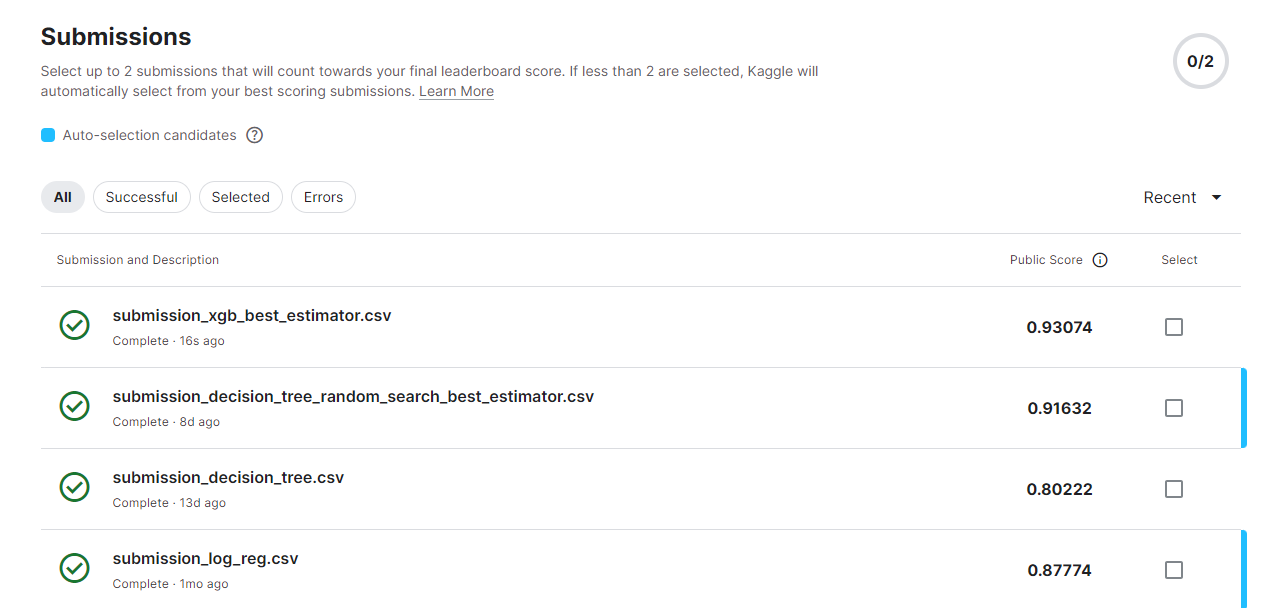